In [51]:
from lightkurve import KeplerLightCurveFile, KeplerTargetPixelFile
from george import kernels
from george.metrics import Metric
import matplotlib.pyplot as pl
import numpy as np
import george
from astropy.stats import median_absolute_deviation

In [52]:
strLC = KeplerLightCurveFile.from_archive(206208968)
strPF = KeplerTargetPixelFile.from_archive(206208968)

Found 1 File(s)
INFO: Found cached file ./mastDownload/K2/ktwo206208968-c03_lc/ktwo206208968-c03_llc.fits with expected size 368640. [astroquery.query]
Found 1 File(s)
INFO: Found cached file ./mastDownload/K2/ktwo206208968-c03_lc/ktwo206208968-c03_lpd-targ.fits.gz with expected size 6948542. [astroquery.query]


/anaconda/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/anaconda/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


Loading BokehJS ...

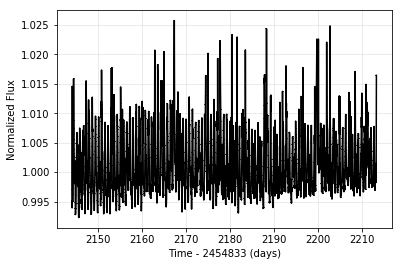

Output()

In [53]:
strPDC = strLC.PDCSAP_FLUX.remove_outliers()
strPDC.plot()
strPF.interact(lc = strPDC)

0.0042533576
3.0345394e-05


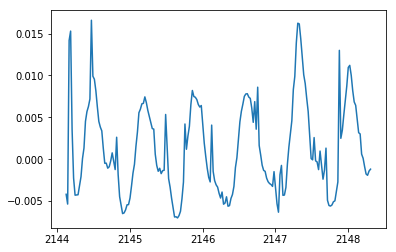

In [54]:
y = strPDC.flux[:200]
x = strPDC.time[:200]
y = (y/np.median(y)) - 1 # sets the function to begin at 0
x = x[np.isfinite(y)]
y = y[np.isfinite(y)] # removes NaN values

pl.plot(x,y)
print(median_absolute_deviation(y))
print(np.var(y))


initial ln-likelihood: 137.95


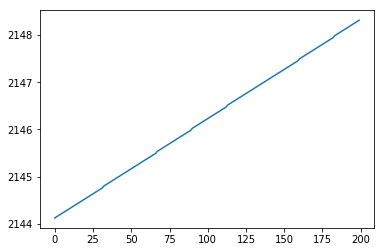

In [58]:
kernel = np.var(y) * kernels.CosineKernel(1.0e-5) # not sure what im doing here!
gp = george.GP(kernel)
gp.compute (x, yerr)
x_pred = x

predVar = gp.predict(y,x_pred,return_var=True)
pl.plot(x_pred)
print ("initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y))) 

In [56]:
from scipy.optimize import minimize 

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)


result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\n Final ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: -138.0193225380938
 hess_inv: array([[6.20788192e+04, 1.79035580e+03],
       [1.79035580e+03, 5.26348284e+01]])
      jac: array([5.45806212e-06, 2.29038204e-06])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 14
     njev: 16
   status: 0
  success: True
        x: array([-19.91340093,  -0.27737568])

 Final ln-likelihood: 138.02


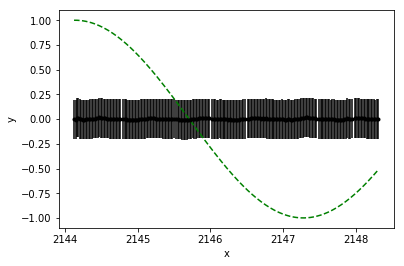

In [57]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

pl.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.plot(x_pred, np.sin(x_pred), "--g")
pl.xlabel("x")
pl.ylabel("y");
